# Figure 1 Final

Notebook to make figure 1 for ms <br>
by Cascade Tuholske 2020.02.23

In [2]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [4]:
#### Functions
def pop_stat(df, geog, stats):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography"""

    # Get results
    labels = []
    delt_list = []
    r2_list = []
    coef_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[stats].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        r2 = model.rsquared_adj
        p = model.pvalues[0]

        # Pop change
        delt = df_geog.drop_duplicates('ID_HDC_G0').copy()
        delt['delt_pop'] = delt['P2016'] - delt['P1983']
        delt = delt['delt_pop'].sum()


        # Make lists
        labels.append(label)
        r2_list.append(r2)
        coef_list.append(coef)
        p_list.append(p)
        delt_list.append(delt)

    # Make data frame
    df_out[geog] = labels
    df_out['p_delt'] = delt_list
    df_out['r2'] = r2_list
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]

    return df_out

In [ ]:
#### Make Figure
fig, axs = plt.subplots(4, 2, figsize = (15, 15), sharex=True)
axs = axs.ravel()
counter = 0

for i, region in enumerate(sig_regions):
    
    df_region = raw_stats[raw_stats[geog] == region] # select region
    
    # Get people days dues to heat coef
    heat = pop_stat(df_region, 'ID_HDC_G0', 'people_days_heat') # get stats 
    #heat = heat[heat['p_value'] < 0.05] # subset by p value
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    
    # Get people days total
    pdays_all = pop_stat(df_region, 'ID_HDC_G0', 'people_days_pop') # get stats
    pdays_all.rename(columns={"coef": "coef_pop"}, inplace = True)
    
    # try to merge them
    heat = heat.merge(pdays_all[['ID_HDC_G0', 'coef_pop']], on = 'ID_HDC_G0', how = 'left')
    
    # plots
    a = i + counter
    im  = axs[a].scatter(np.log10((heat['coef_pop'])*10**9), np.log10(heat['coef_heat']*10**9), alpha = 0.7)# 
                  #,c = heat['coef_pday']*10**6, cmap = 'copper_r')
    axs[a].set_title(region, fontsize = 14)
    
    #fig.colorbar(ax = axs[a], mappable = im)

fig.text(0.5, 0.08, 'Annual increase in people-days [log10] due to population', ha='center', size = 16)
fig.text(0.07, 0.5, 'Annual increase in people-days [log10] due to heat', va='center', rotation='vertical',
        size = 16)
plt.savefig(FIG_OUT+'FIG2.png') 

In [51]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
FN_IN = 'processed/All_data_HI406_figdata.csv'
stats = pd.read_csv(DATA_IN+FN_IN)

# scale the date in the plot 
scale = 10**9 

In [59]:
#### Get Regions
geog = 'sub-region'
meta_fn = 'processed/All_data_HI406_meta.csv'
meta = pd.read_csv(DATA_IN+meta_fn)
meta = meta[[geo, 'ID_HDC_G0']]
stats = stats.merge(meta, on = 'ID_HDC_G0', how = 'inner')

In [60]:
stats.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop,sub-region
0,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.0,Northern America
1,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.0,Northern America
2,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.0,Northern America
3,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.0,Northern America
4,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.0,Northern America


In [69]:
#### Find Regions where the trend in people days due to heat is sig at 0.05

# Args
heat_stat = 'total_days'
pdays_stat = 'people_days'
geog = 'sub-region'

# Find Sig Regions
df_region = pop_stat(stats, geog, heat_stat)
df_region = df_region[df_region['p_value'] < 0.05]

# Get the regions in a list and re-order 
sig_regions = list(df_region[geog])
sig_regions = [sig_regions[10], sig_regions[11],  sig_regions[4],
               sig_regions[6], sig_regions[1], sig_regions[9],
               sig_regions[7], sig_regions[8], sig_regions[5],
               sig_regions[0], sig_regions[3], sig_regions[2]]

In [70]:
len(sig_regions)

12

Text(0.07, 0.5, 'Annual increase in people-days [log10] due to heat')

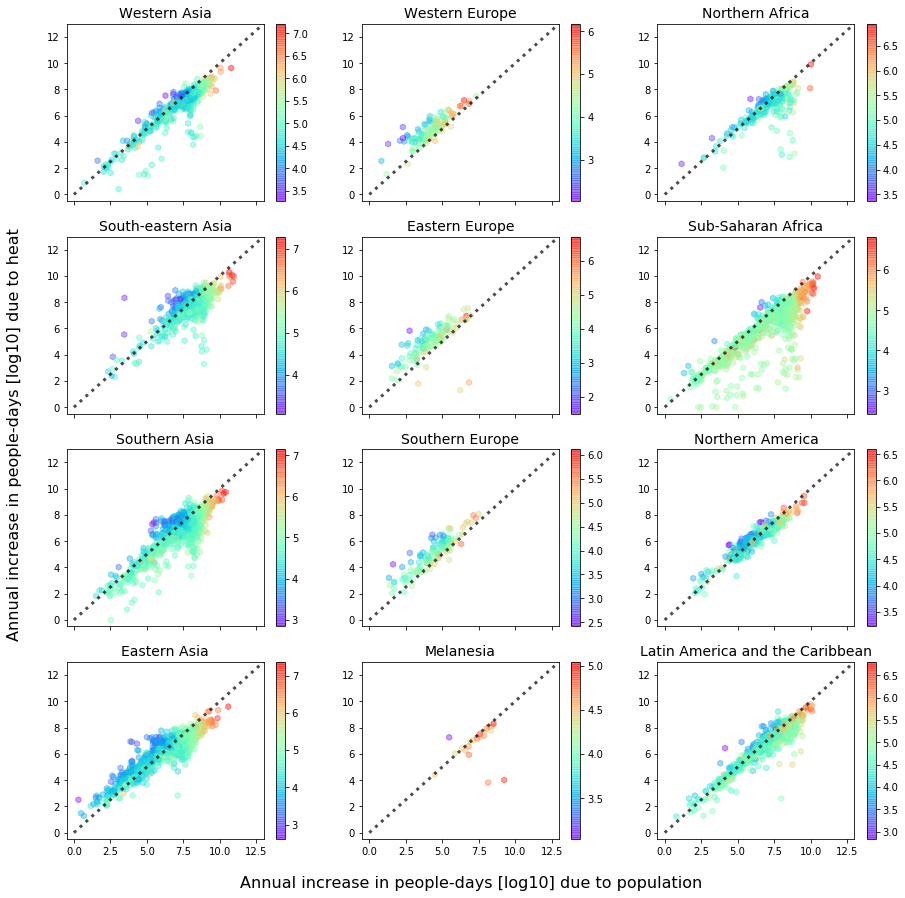

In [71]:
#### Plot and Save Figure
fig, axs = plt.subplots(4, 3, figsize = (15, 15), sharex=True)
axs = axs.ravel()
counter = 0
lim = 13

for i, region in enumerate(sig_regions):
    
    df_region = stats[stats[geog] == region] # select region
    
    # Get people days dues to heat coef
    heat = pop_stat(df_region, 'ID_HDC_G0', 'people_days_heat') # get stats 
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    
    # Get people days total
    pdays_all = pop_stat(df_region, 'ID_HDC_G0', 'people_days_pop') # get stats
    pdays_all.rename(columns={"coef": "coef_pop"}, inplace = True)
    
    # Merge pdays_all and heat
    heat = heat.merge(pdays_all[['ID_HDC_G0', 'coef_pop']], on = 'ID_HDC_G0', how = 'left')
    
    # drop negitive and zero slopes
    heat = heat[heat['coef_heat'] > 0]
    heat = heat[heat['coef_pop'] > 0]
    
    # get data for plot
    X = np.log10(heat['coef_pop']*scale)
    Y = np.log10(heat['coef_heat']*scale)
    C = np.log10(heat['p_delt'])
    
    # drop all slopes below 10^0
    X = X * (X > 0)
    Y = Y * (Y > 0)
    
    # plots
    a = i + counter
    im  = axs[a].scatter(X, Y, alpha = 0.4, marker = 'h', c = C, cmap = 'rainbow')
    axs[a].set_title(region, fontsize = 14)
    
    # Set limits
    axs[a].set_xlim([-0.5, lim])
    axs[a].set_ylim([-0.5, lim])
    
    # Make one-to-one-line
    axs[a].plot([0, lim], [0, lim], ':', lw=3, alpha = 0.7, color = 'black')
    
    fig.colorbar(ax = axs[a], mappable = im)

fig.text(0.5, 0.08, 'Annual increase in people-days [log10] due to population', ha='center', size = 16)
fig.text(0.07, 0.5, 'Annual increase in people-days [log10] due to heat', va='center', rotation='vertical',
        size = 16)

#plt.savefig(FIG_OUT+'FIG2.png') 